<a href="https://colab.research.google.com/github/tsangwai2009/MachineLearn/blob/master/(test)Transfer_Learning_with_Image_Argument.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Preparation before start (install and import)**

tensorflow==2.0.0-beta1 - 仅支持 CPU 的预览 TensorFlow 2.0 测试版（不稳定）

tensorflow-gpu==2.0.0-beta1 - 支持 GPU 的预览 TensorFlow 2.0 测试版（不稳定，适用于 Ubuntu 和 Windows）

tensorflow - 仅支持 CPU 的最新稳定版（适用于 Ubuntu 和 Windows）

tensorflow-gpu - 支持 GPU 的最新稳定版（适用于 Ubuntu 和 Windows）

tf-nightly - 仅支持 CPU 的预览每夜版（不稳定）

tf-nightly-gpu - 支持 GPU 的预览每夜版（不稳定，适用于 Ubuntu 和 Windows）

In [0]:
!pip install tf-nightly-gpu

##Pre-trained layer
  - tensorflow_hub

##Get Data Resources
  - tensorflow_datasets

In [0]:
!pip install "tensorflow_hub==0.4.0"
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (1.1.0)


In [0]:
import matplotlib.pylab as plt

import tensorflow as tf
tf.enable_eager_execution() #Eager Execution 是一种命令式编程环境，可立即评估操作

import tensorflow_hub as hub

import tensorflow_datasets as tfds

from tensorflow.keras import layers

import numpy as np
#ImageDataGenerator for using other resources dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#For using other resources dataset to store and sort the data into training_set and validation_set
import os
import glob
import shutil
#For single image predict
import PIL.Image as Image


W0815 08:27:27.455642 140701400000384 __init__.py:689] 

  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  


##Report TensorFlow Error

In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

===========================================================================================================================

## Step 1: Download the dataset and spilt it into training and validation

###Method 1: Use TensorFlow Datasets

Goto  [TensorFlow Datasets](https://www.tensorflow.org/datasets/datasets#tf_flowers) and check what dataset can be used and the metadata(info) of the dataset

(Info can be: already spilt into train and validation? count of data? supervised?)

Case 1: Not splited, splits the data by Split.ALL/TRAIN.subsplit(weighted):

In [0]:
splits = tfds.Split.ALL.subsplit([70, 30]) #70% training_set, 30% validation_set

(training_set, validation_set), dataset_info = tfds.load('tf_flowers', with_info=True, as_supervised=True, split=splits) #Return splited train_set and valid_set

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/1.0.0. Subsequent calls will reuse this data.


Store the number of examples:

In [0]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2590
Total Number of Validation Images: 1080 



Case 2: Splited, directly load the dataset

In [0]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True) #Return dataset include all original splits
training_set, validation_set = dataset['train'], dataset['test']

Store the number of examples:

In [0]:
num_classes = dataset_info.features['label'].num_classes
num_training_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

###Method 2: Use Other Resources (zip,tgz)




 We may make use of the class
**tf.keras.preprocessing.image.ImageDataGenerator**
which can read data from disk. We therefore can directly download dataset from a URL and unzip it to the Colab filesystem. You may need to spilt the data yourself by putting the images into "train" and "validation" folders.

In [0]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

Check the folder name to confirm the class of images and the existing of train and valid folder

In [0]:
!find $base_dir -type d -print

/root/.keras/datasets/flower_photos
/root/.keras/datasets/flower_photos/daisy
/root/.keras/datasets/flower_photos/tulips
/root/.keras/datasets/flower_photos/roses
/root/.keras/datasets/flower_photos/sunflowers
/root/.keras/datasets/flower_photos/train
/root/.keras/datasets/flower_photos/train/daisy
/root/.keras/datasets/flower_photos/train/tulips
/root/.keras/datasets/flower_photos/train/roses
/root/.keras/datasets/flower_photos/train/sunflowers
/root/.keras/datasets/flower_photos/train/dandelion
/root/.keras/datasets/flower_photos/val
/root/.keras/datasets/flower_photos/val/daisy
/root/.keras/datasets/flower_photos/val/tulips
/root/.keras/datasets/flower_photos/val/roses
/root/.keras/datasets/flower_photos/val/sunflowers
/root/.keras/datasets/flower_photos/val/dandelion
/root/.keras/datasets/flower_photos/dandelion


There should be 5 classes:

In [0]:
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

Since no train and validation folder to store image, create folders and move images according their classes

Eg.Change the following structure:
<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>diasy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
</pre>

To be:
<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>diasy(empty)</b>
|__ <b>dandelion(empty)</b>
|__ <b>roses(empty)</b>
|__ <b>sunflowers(empty)</b>
|__ <b>tulips(empty)</b>
|__ <b>train</b>
    |______ <b>daisy</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>dandelion</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>roses</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>sunflowers</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>tulips</b>: [1.jpg, 2.jpg, 3.jpg ....]
 |__ <b>val</b>
    |______ <b>daisy</b>: [507.jpg, 508.jpg, 509.jpg ....]
    |______ <b>dandelion</b>: [719.jpg, 720.jpg, 721.jpg ....]
    |______ <b>roses</b>: [514.jpg, 515.jpg, 516.jpg ....]
    |______ <b>sunflowers</b>: [560.jpg, 561.jpg, 562.jpg .....]
    |______ <b>tulips</b>: [640.jpg, 641.jpg, 642.jpg ....]
</pre>

In [0]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  num_train = int(round(len(images)*0.8))
  train, val = images[:num_train], images[num_train:]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Images


Error: ignored

In [0]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

================================================================================================================================


##Data Argument(For Dataset from other resources using ImageDataGenerator)

###Set model parameter (IMG_SHAPE, BATCH_SIZE)

In [0]:
IMG_SHAPE = 224 #Fulfill mobileNet Input shape, edit if changed to different model

BATCH_SIZE = 32

###Create a Data Generator for the Training Set (Apply Data Argument, resize and batch)


In [0]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )


train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=BATCH_SIZE,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

Found 2935 images belonging to 5 classes.


###Create a Data Generator for the Validation Set(Only resize and batch)


In [0]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 735 images belonging to 5 classes.


###Count the amount of data

In [0]:
num_classes = len(classes)
num_training_examples = train_data_gen.n
num_test_examples = val_data_gen.n

=================================================================================================================================

##Data Argument(From tfds)

###Set model parameter (IMG_SHAPE, BATCH_SIZE)

In [0]:
IMG_SHAPE = 224

BATCH_SIZE = 32


###Reformat Images and Create Batches

In [0]:
def format_image(image, label):
  image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))/255.0
  return image, label

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

==============================================================================================================================

## Transfer Learning

###Create Feature Extractor(Pre-trained model)

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMG_SHAPE, IMG_SHAPE, 3)) #return the model except the last layer(classifier)

feature_extractor.trainable = False #Freeze the model(weights and bias in the layer will not change after iteration)


###Add classification head

In [0]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes, activation='softmax')
])

model.summary() #check how many variable


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


### Compiler Setup(Optimizer,loss,metrics)

In [0]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

###Train the model(tfds)


In [0]:
EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

NameError: ignored

###Train the model(generator)

In [0]:
epochs = 3
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(BATCH_SIZE)))
)

Epoch 1/3
92/92 [==============================] - 80s 874ms/step - loss: 1.0821 - acc: 0.6099 - val_loss: 0.5934 - val_acc: 0.8190
Epoch 2/3
92/92 [==============================] - 57s 622ms/step - loss: 0.6894 - acc: 0.7857 - val_loss: 0.4756 - val_acc: 0.8639
Epoch 3/3
92/92 [==============================] - 58s 630ms/step - loss: 0.6136 - acc: 0.8129 - val_loss: 0.4680 - val_acc: 0.8789


=========================================================================================================================

## Prediction

### Run on a batch of images

In [0]:

predicted_batch = model.predict(val_data_gen[0])
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = np.array(classes)[predicted_ids]

print(predicted_class_names)


['dandelion' 'tulips' 'daisy' 'roses' 'dandelion' 'roses' 'roses'
 'dandelion' 'daisy' 'sunflowers' 'tulips' 'daisy' 'daisy' 'roses'
 'sunflowers' 'daisy' 'sunflowers' 'sunflowers' 'sunflowers' 'roses'
 'tulips' 'daisy' 'roses' 'sunflowers' 'dandelion' 'roses' 'tulips'
 'dandelion' 'dandelion' 'dandelion' 'roses' 'dandelion']


###Run on a single image

24576/17917 [=========================================] - 0s 0us/step
95.4%


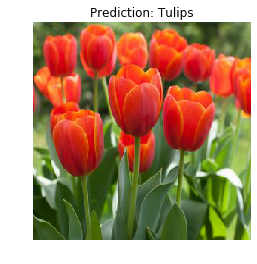

In [0]:
test = tf.keras.utils.get_file('longfield.gardens.Sept_-300x250.jpg','https://ngb.org/wp-content/uploads/2018/09/longfield.gardens.Sept_-300x250.jpg')
test = Image.open(test).resize((IMG_SHAPE, IMG_SHAPE))
test
test = np.array(test)/255.0
test.shape
result = model.predict(test[np.newaxis, ...])

print('{}%'.format(round(np.max(result)*100,2)))

result.shape
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

plt.imshow(test)
plt.axis('off')
predicted_class_names = np.array(classes)[predicted_class]
_ = plt.title("Prediction: " + predicted_class_names.title())